# HW1 Q3 - Convolutional Neural Networks

In this question, we set up a CNN in order to perform the 'Cats vs Dogs' Kaggle challenge

First, we import some PyTorch libraries and direct them to use Google Colab's GPU:

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Sampler, Dataset
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler
from torch.autograd import Variable

import os
import numpy as np
import PIL.Image
import glob
import matplotlib.pyplot as plt


In [0]:
# Use the GPU
device = torch.device('cuda')

In order to import the data for Kaggle from Google Drive, we need to jump through a few hoops, as seen below

In [0]:
# Import the data

from google.colab import drive

drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
PATH = '/content/drive/My Drive/DL_A1/'


# apply several different transforms, as necessary
rotate = [-90, 90]
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(rotate),
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.RandomResizedCrop(64, scale=(0.75, 1.0)),
    transforms.ToTensor()
])

# for the hyperparameter tunning, no transforms were applied

# transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.ToTensor()
# ])

# load the data, which was downloaded and saved 
Data = np.load(PATH +'data.npz')



In [0]:

# we define the dataset class for the train, valid and test data
class dataset(Dataset):
  def __init__(self, X, Y, transform=None):
    self.X = X
    self.Y = Y
    self.transform = transform
  
  def __len__(self):
    return self.X.shape[0]
  
  def __getitem__(self, index):
    #temp = self.transform(self.X[index,:])
    #return temp, self.Y[index]\
    sequence, target = self.X[index], self.Y[index]
    if self.transform is not None:
      sequence = self.transform(sequence)
    if target is None:
      return sequence
    return sequence, target



In [0]:
# define the labels and datasets

test_labels = [None]*Data['Xte'].shape[0]
train_dataset = dataset(Data['Xtr'], Data['y'], transform)
test_dataset = dataset(Data['Xte'], test_labels, transform)
testIDS_list = np.hsplit(Data['testIds'], 1)
testIDS = testIDS_list[0]

In [0]:
# we will define this information now 
batch_size = 64
learning_rate = 0.005
num_epochs = 150

num_classes = 2
num_of_workers = 4

To split the training data into a training and validation set, we need to establish a `sampler` for each that will pull out certain samples when called from the dataloader. In our case, we have a 20% validation split, with 16000 training examples and 4000 validation examples.

In [0]:
# Define a shuffled train and valid index list (non-overlapping)

a = np.arange(19998)
np.random.shuffle(a)

num_train_samples = 16000
num_valid_samples = 19998 - num_train_samples

train_index = a[:num_train_samples]
valid_index = a[num_train_samples:
                num_train_samples+num_valid_samples]


In [0]:

# Fix seed
np.random.seed(42)
torch.manual_seed(42)

# Define samplers for the data (to get validation split)

train_sampler = SubsetRandomSampler(train_index)

valid_sampler = SubsetRandomSampler(valid_index)




As a last step before training, we define training, validation, and test dataloaders that sample from the above `sampler`s according to the defined batch size:

In [0]:

# Get dataloaders for train/valid/test
train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=batch_size,
                                          sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=batch_size,
                                          sampler=valid_sampler)


## CNN architecture definition

Now we define the class for our CNN.

In [0]:
# this is just a function to help with input/output size
def output_size(input_size, kernel_size, stride, padding):
    '''
    Helper function to determine output size of a convolution/pooling.
    '''
    output = int((input_size - kernel_size + 2*(padding)) / stride) + 1
    return output

In [0]:

# hyperparameter tunning 
# Define the CNN class

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 40, kernel_size=3, stride=1, padding=1)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    
    self.conv2 = nn.Conv2d(40, 40, kernel_size=3, stride=1, padding=1)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    
    self.fc1 = nn.Linear(10240, 175)
    self.fc2 = nn.Linear(175, 2)
   
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    x = x.view(len(x), 10240)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
#     x = F.softmax(x)

    return x
  

    

This CNN has two convolutional layers, each with a ReLU activation, a kernel size of 3, a stride of 1, and a padding level of 1. The first convolutional layer learns 18 feature maps and the second learns 64 feature maps. Both convolutional layers use max pooling after their operation, with a kernel size of 2 and stride of 2.
During hyperparameter tuning, these values were modified

Finally, the data will pass through two fully connected layers and output to 2 units representing either a 'Cat' or a 'Dog'.

Below, we see an outline of this architecture. Note that the total number of trainable parameters is around 1.8 million per sample


In [0]:
model = CNN().to(device)
print(model)

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Number of parameters: {}'.format(params))

CNN(
  (conv1): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=10240, out_features=175, bias=True)
  (fc2): Linear(in_features=175, out_features=2, bias=True)
)
Number of parameters: 1808087


## CNN training

Now we will define our loss function and stochastic gradient descent optimizer, and run over the training loop for our CNN.

In [0]:
# Define loss and optimizer

# depending on the method, either NLL or cross entropy loss was used (the latter includes a softmax)
# the former allows for easy visualization of the data
criterion = nn.CrossEntropyLoss()
# criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


# Below is the training and validation loop - it is important to note that, due to random initialization, it can be difficult to reproduce results, and certain runs might converge faster or slower than others. As a reuslt, it might be necessary to run a model several times in order to obtain results seen in the report

In [0]:
# Make a nice progress bar - tqdm on colab is a bit buggy though
from tqdm import tqdm
best_val_acc = 0
# Train
print('\nBeginning training.')
total_step = len(train_loader)
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

for epoch in range(num_epochs):
  print('Epoch {}/{}'.format(epoch+1, num_epochs))
  # Training set
  model.train()
  total_tr, correct_tr = 0, 0
  total_val, correct_val = 0, 0
  mean_train_loss = 0.0
  mean_valid_loss = 0.0
  mean_train_acc = 0.0
  mean_valid_acc = 0.0
  
  output_clear = []
  output_ambig = []
  misclass = []
  for i, (images, labels) in enumerate(tqdm(train_loader, position=0)):
    
    labels = torch.max(labels, 1)[1]
    images, labels = images.to(device), labels.long().to(device)
    optimizer.zero_grad()
   

    # Forward
    outputs = model(images)
    
    # Check if classifications are close (ambiguous) or far apart (clear)
    for j in range(outputs.shape[0]):
      outputs_cpu = outputs.cpu().detach().numpy()
      if abs(outputs_cpu[j,1]-outputs_cpu[j,0] > 0.4):
        output_clear.append(images[j].cpu().numpy())
      if abs(outputs_cpu[j,1]-outputs_cpu[j,0] < 0.1):
        output_ambig.append(images[j].cpu().numpy())
        
       
    loss = criterion(outputs, labels) 
    



# try this implementation
    lambda1 = 0.5
    lambda2 = 2.75
    l1_regularization, l2_regularization = torch.tensor(0), torch.tensor(0)
#     for param in model.parameters():
#       l1_regularization += torch.norm(param, 1).long()
#       l2_regularization += torch.norm(param, 2).long()
#     loss = criterion(outputs, labels) + lambda2 * l2_regularization
    mean_train_loss += loss
  
    # Backward
    loss.backward()
    optimizer.step()
    
#     modify learning rate, if desired
#     if epoch%200 == 0:
#       learning_rate = learning_rate/5
#       optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    # Track loss and accuracy
    
    total_tr += labels.size(0)
    _, predicted_tr = torch.max(outputs.data, 1)
    correct_tr += (predicted_tr == labels).sum().item()
    incorrect_tr = (predicted_tr != labels).cpu().detach().numpy()
    
    # Keep track of wrongly classified items
    for k in range(outputs.shape[0]):
      if incorrect_tr[k] == 1: # If misclassified
        misclass.append(images[k].cpu().numpy())
    acc_tr = correct_tr/total_tr
    mean_train_acc += acc_tr

  
  mean_train_loss /= i+1
  mean_train_acc /= i+1
  pred_total = 0
  labels_total = 0
  
  # Validation set
  model.eval()
  for i, (images, labels) in enumerate(valid_loader):

    labels = torch.max(labels, 1)[1]
    images, labels = images.to(device), labels.long().to(device)
    valid_outputs = model(images)
    valid_loss = criterion(valid_outputs, labels)
    mean_valid_loss += valid_loss
    
    total_val += labels.size(0)
    _, predicted_val = torch.max(valid_outputs.data, 1)
    correct_val += (predicted_val == labels).sum().item()
    valid_acc = correct_val/total_val
    mean_valid_acc += valid_acc
  mean_valid_loss /= i+1
  mean_valid_acc /= i+1
  
  
  
  train_losses.append(mean_train_loss.item())
  train_accuracies.append(mean_train_acc)
  valid_losses.append(mean_valid_loss.item())
  valid_accuracies.append(mean_valid_acc)
  # Mod this when num epochs is too big
  print('\ntrain_loss: {}, train_acc: {}, valid_loss: {}, valid_acc: {}'.format(
      mean_train_loss.item(), mean_train_acc*100, mean_valid_loss.item(), mean_valid_acc*100))
  


  0%|          | 0/250 [00:00<?, ?it/s]


Beginning training.
Epoch 1/150


100%|██████████| 250/250 [00:17<00:00, 14.22it/s]



train_loss: 0.6929819583892822, train_acc: 49.72084538378913, valid_loss: 0.6921926140785217, valid_acc: 57.117153450918245
Epoch 2/150


100%|██████████| 250/250 [00:17<00:00, 14.55it/s]



train_loss: 0.6921353936195374, train_acc: 52.59876953187479, valid_loss: 0.691154420375824, valid_acc: 52.4917319086595
Epoch 3/150


100%|██████████| 250/250 [00:17<00:00, 14.38it/s]



train_loss: 0.6914548873901367, train_acc: 54.43658648789052, valid_loss: 0.6907534599304199, valid_acc: 55.89929839372515
Epoch 4/150


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.6905708312988281, train_acc: 54.856947846587126, valid_loss: 0.6902555823326111, valid_acc: 53.46618259140866
Epoch 5/150


100%|██████████| 250/250 [00:17<00:00, 14.19it/s]



train_loss: 0.6896244287490845, train_acc: 55.1715324341284, valid_loss: 0.6897340416908264, valid_acc: 52.51923828744407
Epoch 6/150


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.6885411739349365, train_acc: 55.434398174448084, valid_loss: 0.6880851984024048, valid_acc: 55.244815836604374
Epoch 7/150


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.6873008608818054, train_acc: 57.00500528378507, valid_loss: 0.6856411099433899, valid_acc: 57.683034423386815
Epoch 8/150


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.6859132647514343, train_acc: 57.47056194401951, valid_loss: 0.6847419738769531, valid_acc: 54.76018052949874
Epoch 9/150


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.6837262511253357, train_acc: 56.88798342547131, valid_loss: 0.6832066178321838, valid_acc: 56.5187332056551
Epoch 10/150


  0%|          | 0/250 [00:00<?, ?it/s]


train_loss: 0.6820378303527832, train_acc: 57.45878078927399, valid_loss: 0.6787055730819702, valid_acc: 59.34967655559753
Epoch 11/150


 20%|██        | 50/250 [00:03<00:13, 14.73it/s]

KeyboardInterrupt: ignored

# In order to plot the images, we will use the following code. Please note that the loops will take a while to run.

In [0]:

output_ambig = np.array(output_ambig)
output_clear = np.array(output_clear)
misclass = np.array(misclass)

# This is inefficient, but works!
ambig_and_wrong, clear_and_wrong = [], []
for item in misclass:
  if item in output_ambig:
    ambig_and_wrong.append(item)
  elif item in output_clear:
    clear_and_wrong.append(item)
    
print('We have',len(ambig_and_wrong),' samples that were misclassified and were ambiguous')
print('We have', len(clear_and_wrong),' samples that were clearly misclassified')


NameError: ignored

# We can plot the images below. Please note that only some images were chosen for the report

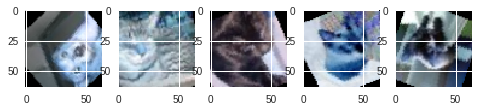

In [0]:

w=20
h=20
fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 1
for i in range(5):
  img = np.transpose(ambig_and_wrong[i])
  fig.add_subplot(rows, columns, i + 1)
  plt.imshow(img)
plt.show()


# We can also plot the kernels too, although interpretation is more difficult

ValueError: ignored

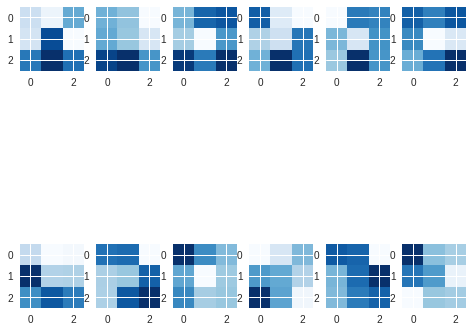

In [0]:
# we can plot the kernels too

def plot_kernels():
  w = 12
  h = 12
  fig=plt.figure(figsize=(8, 8))
  columns = 8
  rows = 6
  weight_cpu = model.conv2.weight.data.cpu()
  weight_np = weight_cpu.detach().numpy()
  for i in range(40):
    img = weight_np[i,0,:,:]
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(img, cmap = 'Blues')
  plt.show()

plot_kernels()


# Finally, we can plot the learning curves for our training and validation run

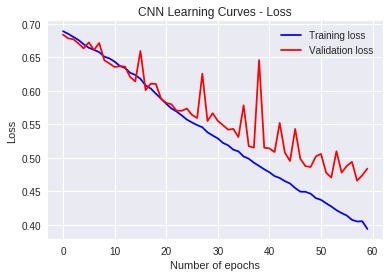

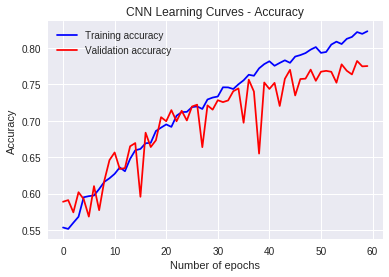

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.title('CNN Learning Curves - Loss')
plt.plot(range(num_epochs), train_losses, color='blue', label='Training loss')
plt.plot(range(num_epochs), valid_losses, color='red', label='Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.title('CNN Learning Curves - Accuracy')
plt.plot(range(num_epochs), train_accuracies, color='blue', label='Training accuracy')
plt.plot(range(num_epochs), valid_accuracies, color='red', label='Validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## CNN Testing

Now we evaluate the test performance of our CNN.

Beginning testing
4999


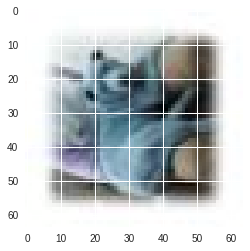

In [0]:
# define the transforms and dataloaders for the test set
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

test_sampler = SequentialSampler(np.arange(len(testIDS)))

test_loader = torch.utils.data.DataLoader(test_dataset,
                                         batch_size=batch_size,
                                         sampler=test_sampler)

# Test the model
model.eval()
with torch.no_grad():
  count = 1
  for images in test_loader: 
 
    just_image = images[0,:,:,:]
    a = np.transpose(just_image)
    plt.imshow(a)
    
    
    images = images.to(device)
    outputs = model(images)
    
#     convert and stack outputs
    outputs_cpu = outputs.cpu()
    temp = outputs_cpu.detach().numpy()
    if count == 1:
      test_out = temp
    else:
      test_out = np.vstack((test_out, temp))  

    count += 1
print('Beginning testing')
print(len(test_out))

In [0]:
# pickle and save results to submit for kaggle

import pandas as pd
import numpy as np
import pickle
import os
import csv

currPath = os.getcwd()
prediction = []
# convert softmax to cat/dog
for i in range(len(test_out)):
  if test_out[i, 0] > test_out[i, 1]:
    prediction.append('Cat')
  else:
    prediction.append('Dog')

    
    
  
# build csv and submit
with open(PATH +'test_predicted.csv', 'w') as csvfile:
    # defined by the sample csv
    fieldnames = ['Id', 'label']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for i in range(len(prediction)):
      writer.writerow({'Id': testIDS[i], 'label':prediction[i]})

      

*Include a comparison with the performance of the MLP from Q1, once we've done Q1.*